In [7]:
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import glob
from glob import glob
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
import h5py
import pickle

dataset = pd.read_csv('driver_imgs_list.csv')
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [8]:
# Groupby subjects
by_drivers = dataset.groupby('subject') 
# Groupby unique drivers
unique_drivers = by_drivers.groups.keys() # drivers id
print('There are : ',len(unique_drivers), ' unique drivers')
print('There is a mean of ',round(dataset.groupby('subject').count()['classname'].mean()), ' images by driver.')

There are :  26  unique drivers
There is a mean of  862  images by driver.


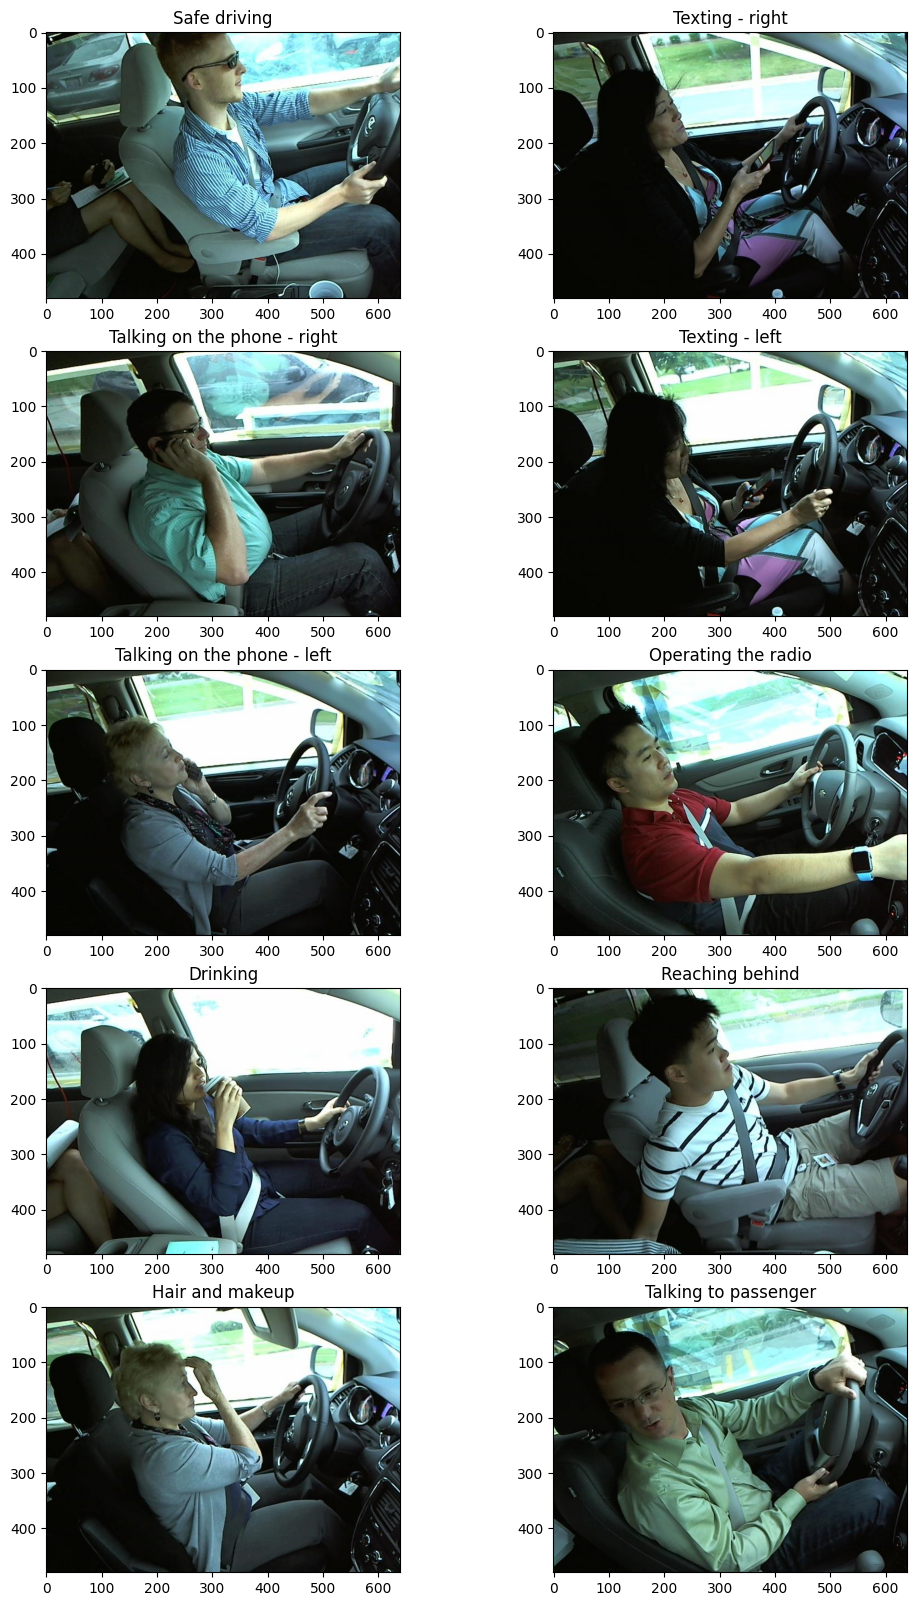

In [9]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = 'imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

C:\Users\hp\AppData\Local\Temp\ipykernel_17292\3038481671.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'classname', data = dataset, palette='Set2')


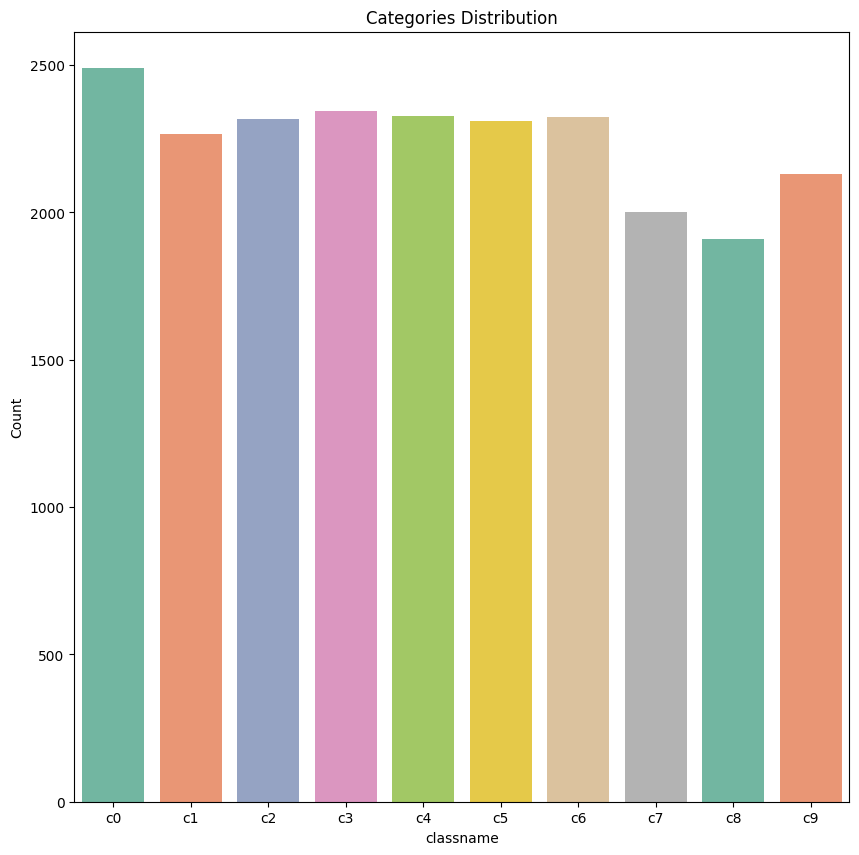

In [10]:
# Plot figure size
plt.figure(figsize = (10,10))
# Count the number of images per category
sns.countplot(x = 'classname', data = dataset, palette='Set2')
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.show()

In [11]:
def load_and_resize_images(base_dir, target_size=(64, 64)):
    all_images = []
    all_labels = []
    for label in range(10):
        label_str = f'{base_dir}/c{label}'
        image_paths = glob(os.path.join(label_str, '*.jpg'))
        for image_path in image_paths:
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, target_size)
                all_images.append(image)
                all_labels.append(label)
    return np.array(all_images, dtype=np.uint8), np.array(all_labels)

# Load and resize images
base_dir = 'imgs/train'
images, labels = load_and_resize_images(base_dir)

# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.20, stratify=labels, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, stratify=y_train, random_state=42
)

# Save datasets to disk using HDF5
with h5py.File('dataset.h5', 'w') as hf:
    hf.create_dataset('X_train', data=X_train)
    hf.create_dataset('y_train', data=y_train)
    hf.create_dataset('X_val', data=X_val)
    hf.create_dataset('y_val', data=y_val)
    hf.create_dataset('X_test', data=X_test)
    hf.create_dataset('y_test', data=y_test)

# Print the final sizes
print(f'Final training set size: {X_train.shape[0]} images')
print(f'Final validation set size: {X_val.shape[0]} images')
print(f'Final testing set size: {X_test.shape[0]} images')

# Load datasets from disk
with h5py.File('dataset.h5', 'r') as hf:
    X_train_loaded = hf['X_train'][:]
    y_train_loaded = hf['y_train'][:]
    X_val_loaded = hf['X_val'][:]
    y_val_loaded = hf['y_val'][:]
    X_test_loaded = hf['X_test'][:]
    y_test_loaded = hf['y_test'][:]


Final training set size: 16145 images
Final validation set size: 1794 images
Final testing set size: 4485 images


In [12]:
# Combine training and validation data for cross-validation
X_combined = np.concatenate((X_train, X_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)

# Define Random Forest classifier
clf_rf = RandomForestClassifier(n_estimators=20, random_state=42)

# Perform Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf_rf, X_combined.reshape(X_combined.shape[0], -1), y_combined, cv=skf)

# Train the Random Forest model on the entire combined dataset
clf_rf.fit(X_combined.reshape(X_combined.shape[0], -1), y_combined)

# Save the trained Random Forest model
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(clf_rf, f)

# Load the model (for later use)
with open('random_forest_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Use the loaded model to make predictions on the test set
y_test_pred = loaded_model.predict(X_test_loaded.reshape(X_test_loaded.shape[0], -1))

# Print cross-validation scores
print(f'Cross-Validation Accuracy: {np.mean(cv_scores) * 100:.2f}% ')

# Print classification report for Random Forest
report = classification_report(y_test_loaded, y_test_pred, target_names=[f'Class {i}' for i in range(10)])
print("Classification Report:\n", report)

# Load the KNN model (for later use)
with open('random_forest_model.pkl', 'rb') as f:
    loaded_rf_model = pickle.load(f)

# Use the loaded KNN model to make predictions on the test set
y_test_pred_rf_loaded = loaded_rf_model.predict(X_test.reshape(X_test.shape[0], -1))

# Calculate accuracy on the test set for the loaded KNN model
test_accuracy_rf_loaded = accuracy_score(y_test, y_test_pred_rf_loaded)
print(f'Loaded RandomForest Test Accuracy: {test_accuracy_rf_loaded * 100:.2f}%')


Cross-Validation Accuracy: 98.42% 
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.96      1.00      0.98       498
     Class 1       0.99      0.99      0.99       453
     Class 2       0.98      1.00      0.99       464
     Class 3       0.98      0.99      0.99       469
     Class 4       0.98      0.98      0.98       465
     Class 5       1.00      0.98      0.99       463
     Class 6       0.99      0.99      0.99       465
     Class 7       0.99      0.99      0.99       400
     Class 8       1.00      0.95      0.98       382
     Class 9       0.99      0.98      0.98       426

    accuracy                           0.99      4485
   macro avg       0.99      0.99      0.99      4485
weighted avg       0.99      0.99      0.99      4485

Loaded RandomForest Test Accuracy: 98.60%


Confusion Matrix:
 [[497   0   0   0   0   0   0   0   0   1]
 [  1 450   1   0   0   0   0   1   0   0]
 [  1   0 463   0   0   0   0   0   0   0]
 [  2   0   0 464   3   0   0   0   0   0]
 [  4   1   1   0 457   0   1   1   0   0]
 [  0   0   1   1   2 456   1   1   0   1]
 [  1   0   3   2   0   0 459   0   0   0]
 [  3   0   0   1   0   0   0 396   0   0]
 [  4   2   2   3   1   0   2   2 364   2]
 [  5   1   0   1   1   0   1   1   0 416]]


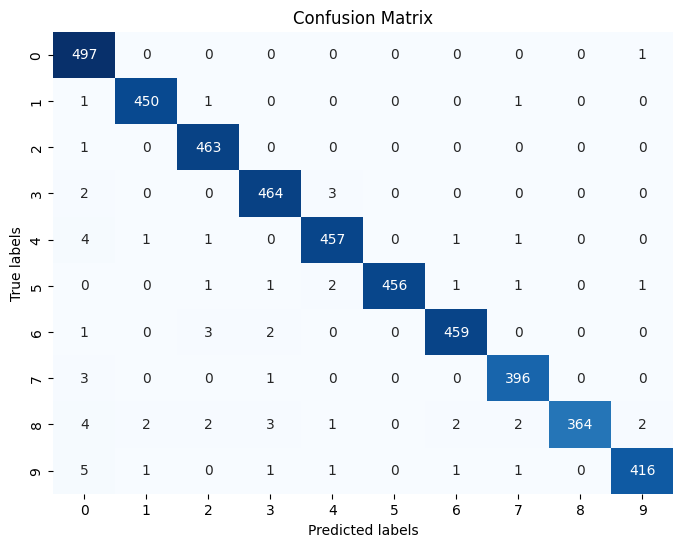

In [13]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [14]:
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Predict on validation set for Decision Tree
y_val_pred_dt = clf_dt.predict(X_val.reshape(X_val.shape[0], -1))

# Calculate accuracy on validation set for Decision Tree
val_accuracy_dt = accuracy_score(y_val, y_val_pred_dt)
print(f'Decision Tree Validation Accuracy: {val_accuracy_dt * 100:.2f}%')

# Save the trained Decision Tree model
with open('decision_tree_model.pkl', 'wb') as f:
    pickle.dump(clf_dt, f)

# Predict on test set for Decision Tree
y_test_pred_dt = clf_dt.predict(X_test.reshape(X_test.shape[0], -1))

# Print classification report for Decision Tree
report_dt = classification_report(y_test, y_test_pred_dt, target_names=[f'Class {i}' for i in range(10)])
print("Decision Tree Classification Report:\n", report_dt)

# Load the Decision Tree model (for later use)
with open('decision_tree_model.pkl', 'rb') as f:
    loaded_dt_model = pickle.load(f)

# Use the loaded Decision Tree model to make predictions on the test set
y_test_pred_dt_loaded = loaded_dt_model.predict(X_test.reshape(X_test.shape[0], -1))

# Calculate accuracy on the test set for the loaded Decision Tree model
test_accuracy_dt_loaded = accuracy_score(y_test, y_test_pred_dt_loaded)
print(f'Loaded Decision Tree Test Accuracy: {test_accuracy_dt_loaded * 100:.2f}%')

Decision Tree Validation Accuracy: 86.23%
Decision Tree Classification Report:
               precision    recall  f1-score   support

     Class 0       0.85      0.84      0.85       498
     Class 1       0.86      0.88      0.87       453
     Class 2       0.84      0.88      0.86       464
     Class 3       0.84      0.88      0.86       469
     Class 4       0.86      0.85      0.85       465
     Class 5       0.94      0.92      0.93       463
     Class 6       0.81      0.83      0.82       465
     Class 7       0.87      0.83      0.85       400
     Class 8       0.81      0.79      0.80       382
     Class 9       0.83      0.81      0.82       426

    accuracy                           0.85      4485
   macro avg       0.85      0.85      0.85      4485
weighted avg       0.85      0.85      0.85      4485

Loaded Decision Tree Test Accuracy: 85.26%


Confusion Matrix:
 [[418   8   5  15  11   1   8   8   6  18]
 [  2 397  11   9   5   5  10   2   5   7]
 [ 12   5 407   6   4   3  14   5   4   4]
 [ 11   4   4 413  19   1   3   3   3   8]
 [ 12   7   8  18 395   3   7   2  10   3]
 [  4   1   3   5   4 425   7   8   2   4]
 [  6  25  17   4   4   3 386   3  14   3]
 [  5   5  14   1   4   2  16 333  11   9]
 [  8   7   9   9   4   3  16   8 303  15]
 [ 13   3   4   9  10   5   7  11  17 347]]


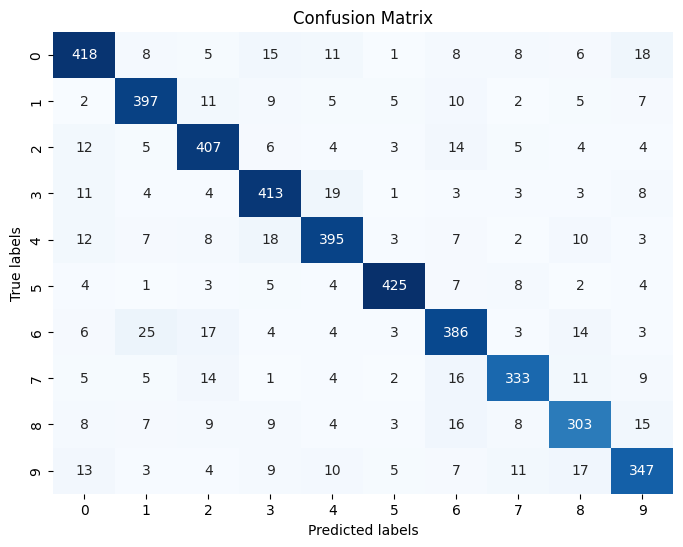

In [15]:
conf_matrix = confusion_matrix(y_test, y_test_pred_dt_loaded)
print("Confusion Matrix:\n", conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Combine training and validation data for cross-validation
X_combined = np.concatenate((X_train, X_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)

# Define K-Nearest Neighbors classifier
clf_knn = KNeighborsClassifier(n_neighbors=20)  # Adjust number of neighbors as needed
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(clf_knn, X_combined.reshape(X_combined.shape[0], -1), y_combined, cv=skf)

print(f'Cross-Validation Accuracy: {np.mean(cv_scores) * 100:.2f}% ')

# Train on the entire combined dataset
clf_knn.fit(X_combined.reshape(X_combined.shape[0], -1), y_combined)

# Save the trained KNN model
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(clf_knn, f)

# Predict on test set for KNN
y_test_pred_knn = clf_knn.predict(X_test.reshape(X_test.shape[0], -1))

# Print classification report for KNN
report_knn = classification_report(y_test, y_test_pred_knn, target_names=[f'Class {i}' for i in range(10)])
print("KNN Classification Report:\n", report_knn)

# Load the KNN model (for later use)
with open('knn_model.pkl', 'rb') as f:
    loaded_knn_model = pickle.load(f)

# Use the loaded KNN model to make predictions on the test set
y_test_pred_knn_loaded = loaded_knn_model.predict(X_test.reshape(X_test.shape[0], -1))

# Calculate accuracy on the test set for the loaded KNN model
test_accuracy_knn_loaded = accuracy_score(y_test, y_test_pred_knn_loaded)
print(f'Loaded KNN Test Accuracy: {test_accuracy_knn_loaded * 100:.2f}%')


Cross-Validation Accuracy: 96.88% 
KNN Classification Report:
               precision    recall  f1-score   support

     Class 0       0.96      0.96      0.96       498
     Class 1       0.98      1.00      0.99       453
     Class 2       0.96      1.00      0.98       464
     Class 3       0.97      0.98      0.97       469
     Class 4       0.95      0.97      0.96       465
     Class 5       1.00      0.98      0.99       463
     Class 6       0.98      0.99      0.99       465
     Class 7       1.00      0.98      0.99       400
     Class 8       0.99      0.91      0.95       382
     Class 9       0.96      0.97      0.97       426

    accuracy                           0.98      4485
   macro avg       0.98      0.97      0.97      4485
weighted avg       0.98      0.98      0.98      4485

Loaded KNN Test Accuracy: 97.53%


Confusion Matrix:
 [[476   2   4   9   3   1   0   0   0   3]
 [  0 453   0   0   0   0   0   0   0   0]
 [  0   0 462   0   0   0   1   0   0   1]
 [  2   0   0 459   8   0   0   0   0   0]
 [  6   2   0   3 453   0   0   0   0   1]
 [  0   0   1   0   5 456   1   0   0   0]
 [  2   0   1   0   1   0 461   0   0   0]
 [  2   1   1   0   0   0   0 394   0   2]
 [  3   2  11   1   4   0   5   0 348   8]
 [  3   1   0   3   1   0   1   0   5 412]]


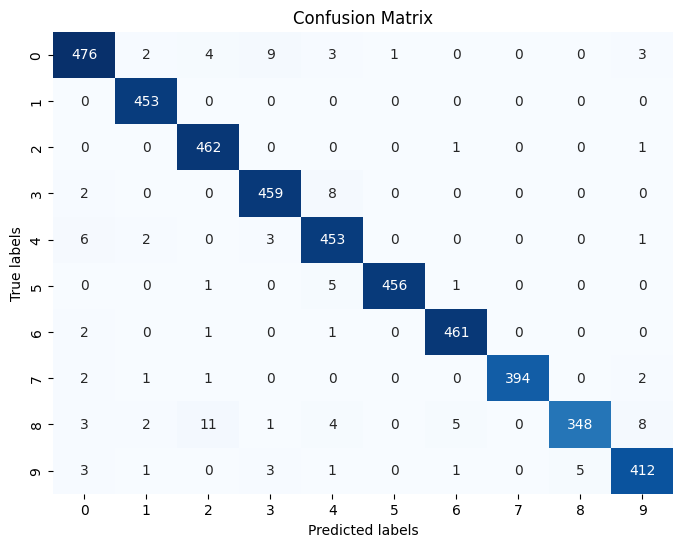

In [17]:
conf_matrix = confusion_matrix(y_test, y_test_pred_knn_loaded)
print("Confusion Matrix:\n", conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

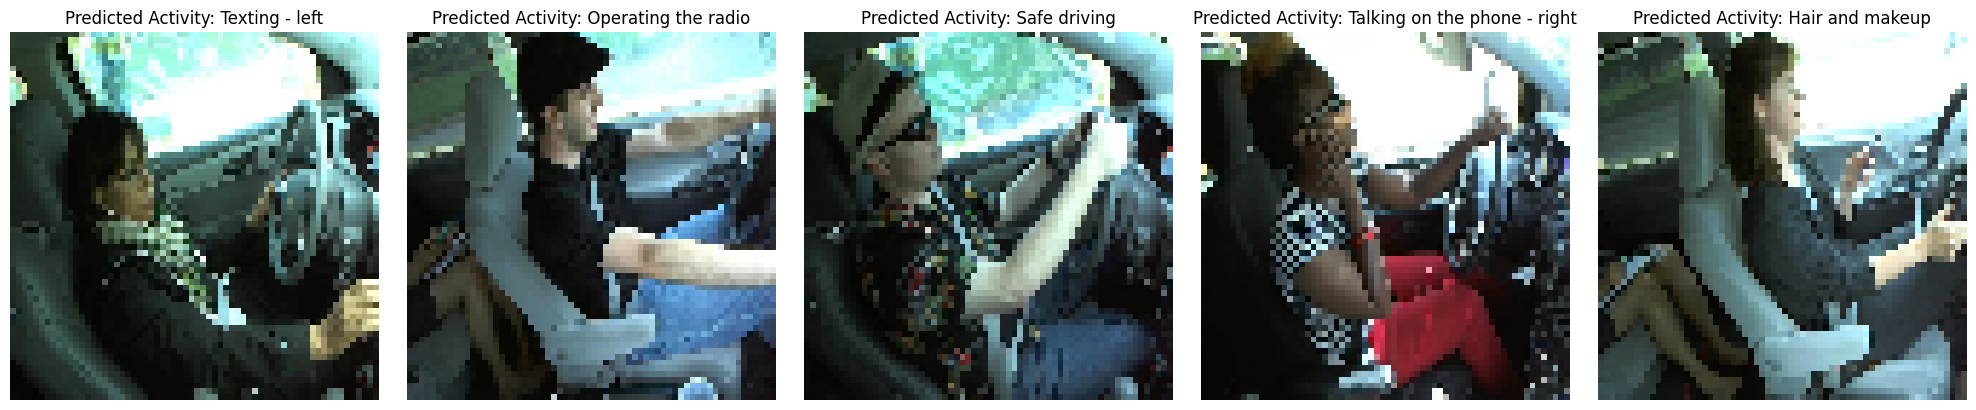

In [21]:
def load_and_preprocess_image(image_path, target_size=(64, 64)):
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.resize(image, target_size)
        return image
    else:
        raise ValueError(f"Image not found or cannot be opened: {image_path}")


test_images_path = 'imgs/test/*.jpg'

# Load all test images
test_image_paths = glob(test_images_path)
# Load the KNN model (for later use)
with open('random_forest_model.pkl', 'rb') as f:
    loaded_rf_model = pickle.load(f)

# Limit the number of test images to process
num_images_to_predict = 5

# Create a figure with a single row of subplots
fig, axes = plt.subplots(1, num_images_to_predict, figsize=(num_images_to_predict * 4, 4))

for idx, image_path in enumerate(test_image_paths[:num_images_to_predict]):
    # Load and preprocess the image
    image = load_and_preprocess_image(image_path)
    image_reshaped = image.reshape(1, -1)

    # Predict the class of the image
    predicted_class_idx = clf_rf.predict(image_reshaped)[0]
    predicted_class_label = f'c{predicted_class_idx}'
    predicted_activity = activity_map[predicted_class_label]

    # Display the image and the predicted activity
    axes[idx].imshow(image)
    axes[idx].set_title(f'Predicted Activity: {predicted_activity}')
    axes[idx].axis('off')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

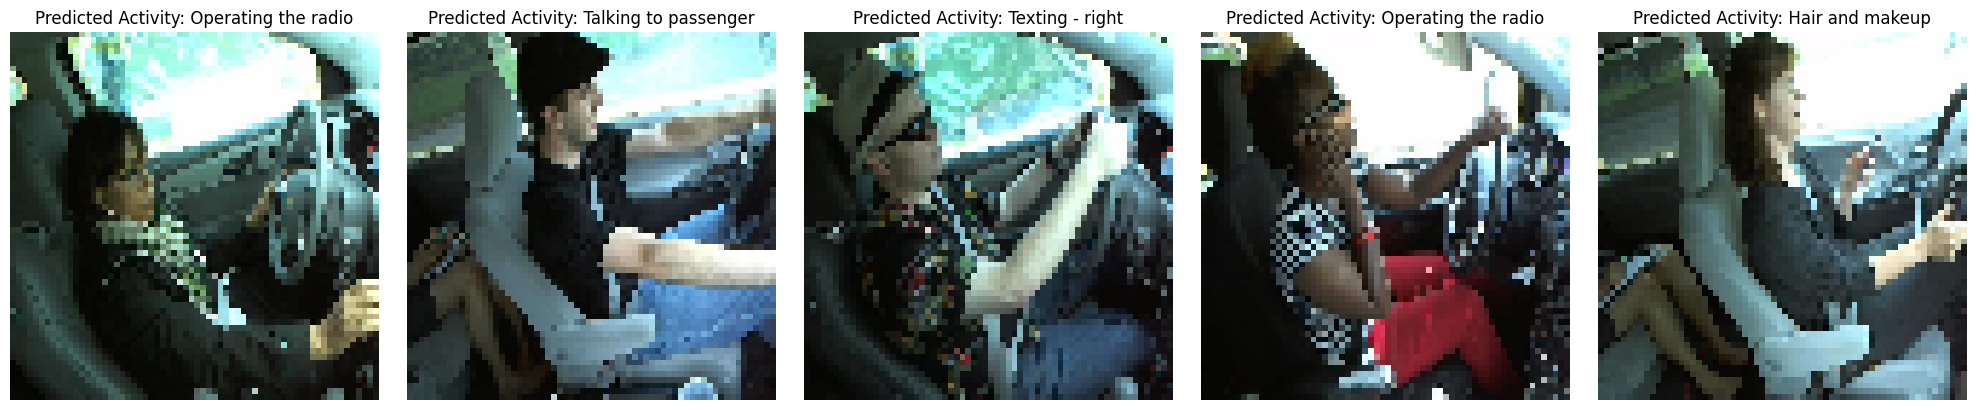

In [19]:
# Load the Decision Tree model (for later use)
with open('decision_tree_model.pkl', 'rb') as f:
    loaded_dt_model = pickle.load(f)

# Number of images to predict and display
num_images_to_predict = 5

# Create a figure with a single row of subplots
fig, axes = plt.subplots(1, num_images_to_predict, figsize=(num_images_to_predict * 4, 4))

for idx, image_path in enumerate(test_image_paths[:num_images_to_predict]):
    # Load and preprocess the image
    image = load_and_preprocess_image(image_path)
    image_reshaped = image.reshape(1, -1)

    # Predict the class of the image
    predicted_class_idx = clf_dt.predict(image_reshaped)[0]
    predicted_class_label = f'c{predicted_class_idx}'
    predicted_activity = activity_map[predicted_class_label]

    # Display the image and the predicted activity
    axes[idx].imshow(image)
    axes[idx].set_title(f'Predicted Activity: {predicted_activity}')
    axes[idx].axis('off')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


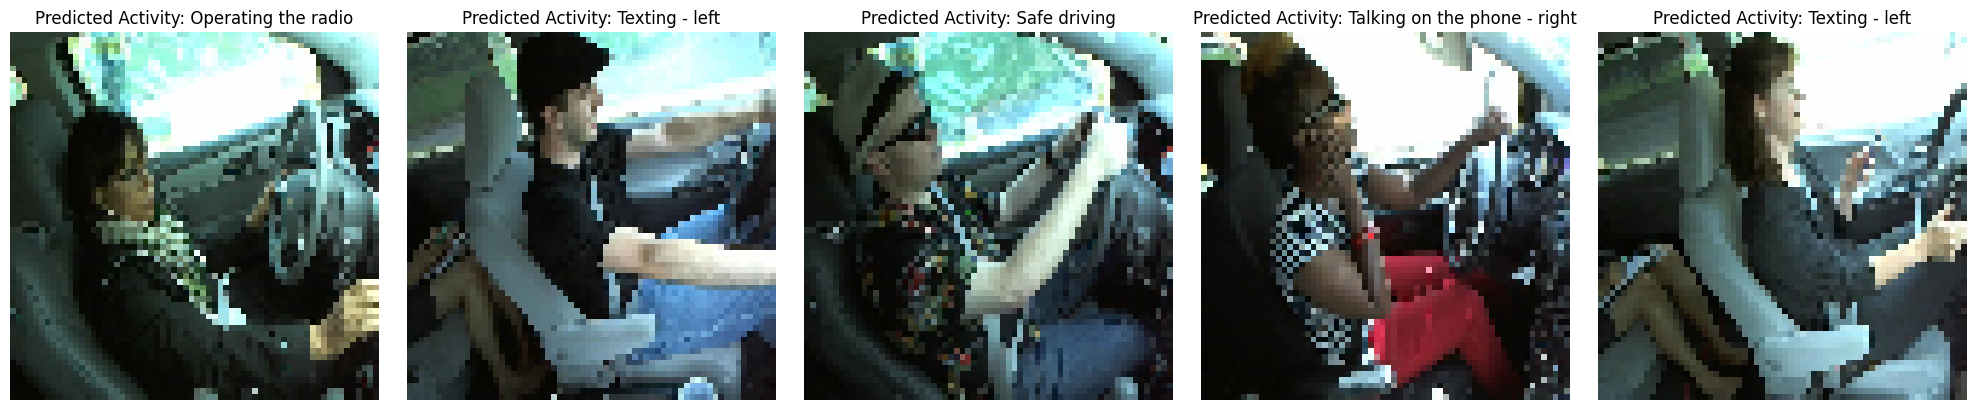

In [22]:

# Number of images to predict and display
num_images_to_predict = 5

# Load the KNN model
with open('knn_model.pkl', 'rb') as f:
    loaded_knn_model = pickle.load(f)

# Create a figure with a single row of subplots
fig, axes = plt.subplots(1, num_images_to_predict, figsize=(num_images_to_predict * 4, 4))

for idx, image_path in enumerate(test_image_paths[:num_images_to_predict]):
    # Load and preprocess the image
    image = load_and_preprocess_image(image_path)
    image_reshaped = image.reshape(1, -1)

    # Predict the class of the image
    predicted_class_idx = loaded_knn_model.predict(image_reshaped)[0]
    predicted_class_label = f'c{predicted_class_idx}'
    predicted_activity = activity_map[predicted_class_label]

    # Display the image and the predicted activity
    axes[idx].imshow(image)
    axes[idx].set_title(f'Predicted Activity: {predicted_activity}')
    axes[idx].axis('off')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()